In [1]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from helpers import *
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
import pickle

# Algorithms
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,ElasticNetCV,ElasticNet
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
import lightgbm as lgb

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
train = pd.read_pickle('../data/feature_engineering/sub_train_bin.pkl')
test = pd.read_pickle('../data/feature_engineering/sub_test_bin.pkl')
p_values_origin = pd.read_pickle('../data/inc_p_values.pkl')
kept_TCRs = p_values_origin.T.nsmallest(101,'p_value').T.columns.values

In [4]:
train_X = train.drop(['sample_name','phenotype_status'],axis=1).values
test_X = test.drop(['sample_name','phenotype_status'],axis=1).values
# train_X = train[kept_TCRs].values
# test_X = test[kept_TCRs].values
train_y = train['phenotype_status'].values
test_y = test['phenotype_status'].values

In [6]:
train_X.shape

(641, 165)

In [5]:
def cal_p_value1(present_c0,present_c1,class_counts,alternative='greater'):
    '''
    present_c0: the number of negative samples where the TCR present
    present_c1: the number of positive samples where the TCR present
    class_counts: the class distribution: [class_negative(0),class_positive(1)]
    alternative: Choose the type of test: greater, less, two_sided

    contingency table: [[present_c1, absent_c1], [present_c0, absent_c0]]
    '''

    absent_c0 = class_counts[0]-present_c0 # the number of negative samples where the TCR absent 
    absent_c1 = class_counts[1]-present_c1 # the number of positive samples where the TCR absent

    # Conducting fisher exact test 
    _, pvalue = fisher_exact([[present_c1, absent_c1], [present_c0, absent_c0]],alternative=alternative)
    return pvalue

In [26]:
nums = np.arange(1,train_X.shape[1]+1)
K = []
cv_auroc = []
for n in nums:
    
    auroc = []
#     lr = LogisticRegression()
    rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)
    kf = StratifiedKFold(10)
    TCRs = train.drop(['sample_name','phenotype_status'],axis=1).columns.values
    for train_index,test_index in kf.split(train_X,train_y): # for each cv round
    #     X_train, X_test = X[train_index], X[test_index]
    #     y_train, y_test = y[train_index], y[test_index]

        train_cv = train.iloc[train_index]
        class_counts = train_cv.phenotype_status.value_counts()
        a = train_cv[train_cv.phenotype_status==0][TCRs].apply(np.count_nonzero,axis=0)
        b = train_cv[train_cv.phenotype_status==1][TCRs].apply(np.count_nonzero,axis=0)
        temp = pd.DataFrame({'status-':a,'status+':b})
        temp['p_value']=temp.apply(lambda row: cal_p_value1(row['status-'], row['status+'],class_counts=class_counts), axis=1)

        kept_TCRs = temp.nsmallest(n,'p_value').T.columns.values
        sub_train_X = train[kept_TCRs]

        X_train, X_test = sub_train_X.iloc[train_index].values, sub_train_X.iloc[test_index].values
        y_train, y_test = train_y[train_index], train_y[test_index]

        rf.fit(X_train,y_train)
        auroc.append(roc_auc_score(y_test,rf.predict_proba(X_test)[:,1]))
    print('Keep NBest:',n,'cv_auroc:',np.mean(auroc))
    cv_auroc.append(np.mean(auroc))

Keep NBest: 1 cv_auroc: 0.5604556650246306
Keep NBest: 2 cv_auroc: 0.6009879584017515
Keep NBest: 3 cv_auroc: 0.6485782703886153
Keep NBest: 4 cv_auroc: 0.6746373836891079
Keep NBest: 5 cv_auroc: 0.703331964969896
Keep NBest: 6 cv_auroc: 0.7250154429587926
Keep NBest: 7 cv_auroc: 0.735753381812495
Keep NBest: 8 cv_auroc: 0.7450705684572679
Keep NBest: 9 cv_auroc: 0.7584205176323403
Keep NBest: 10 cv_auroc: 0.7710604816639299
Keep NBest: 11 cv_auroc: 0.7788280944561732
Keep NBest: 12 cv_auroc: 0.7771029791226836
Keep NBest: 13 cv_auroc: 0.7927511924309953
Keep NBest: 14 cv_auroc: 0.8046057158495582
Keep NBest: 15 cv_auroc: 0.8084091797638596
Keep NBest: 16 cv_auroc: 0.8118598013918211
Keep NBest: 17 cv_auroc: 0.8197134256001251
Keep NBest: 18 cv_auroc: 0.8236361326139651
Keep NBest: 19 cv_auroc: 0.8245693564782235
Keep NBest: 20 cv_auroc: 0.8295967237469701
Keep NBest: 21 cv_auroc: 0.832482993197279
Keep NBest: 22 cv_auroc: 0.8325983266869967
Keep NBest: 23 cv_auroc: 0.8418070216592385


Optimal number of features : 160
AUROC: 0.8871838590508667 Accuracy:  0.8
Best_score: 0.9756016889514427


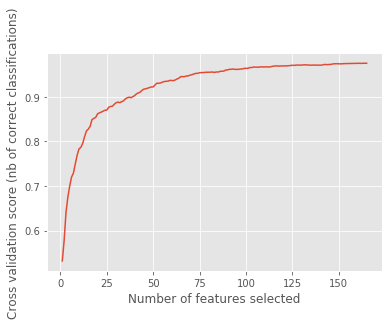

In [17]:
# Define a classifier
lr = LogisticRegression(penalty='l2',C=0.2)
# rf = RandomForestClassifier(n_estimators=100)
# lgbm = lgb.LGBMClassifier()
rfecv = RFECV(lr,cv=StratifiedKFold(10,random_state=0),scoring='roc_auc',step = 1)
rfecv.fit(train_X,train['phenotype_status'])

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test['phenotype_status'],rfecv.predict_proba(test_X)[:,1]),'Accuracy: ',accuracy_score(test['phenotype_status'],
        rfecv.predict(test_X)))
print('Best_score:',max(rfecv.grid_scores_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [15]:
clf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                 max_depth=29, max_features='auto', max_leaf_nodes=49,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=5,
                                 min_weight_fraction_leaf=0.0, n_estimators=170, n_jobs=1,
                                 oob_score=True, random_state=0, verbose=0, warm_start=False)

param_grid = {"n_estimators": np.arange(140, 180, 10),
           "max_depth": np.arange(28, 34, 1),
#           "min_samples_split": np.arange(2,15,1),
          #"min_samples_leaf": np.arange(1,4,1),
         # "max_leaf_nodes": np.arange(48,55,1),
        #   "min_weight_fraction_leaf": np.arange(0,0.12,0.04)
        }

parameter_search(clf2,'grid',param_grid,train_X,train['phenotype_status'].values,test_X,test['phenotype_status'].values)

Parameter_grid: {'n_estimators': array([140, 150, 160, 170]), 'max_depth': array([28, 29, 30, 31, 32, 33])}
Best parameters set found on development set for AUC:

{'max_depth': 31, 'n_estimators': 140}

Best AUC: 0.9693155834702716

Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=49,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

Grid scores on training set:

AUROC: 0.969 (+/-0.034), Accuracy: 0.917 (+/-0.045) for {'max_depth': 28, 'n_estimators': 140}
AUROC: 0.969 (+/-0.035), Accuracy: 0.913 (+/-0.043) for {'max_depth': 28, 'n_estimators': 150}
AUROC: 0.969 (+/-0.036), Accuracy: 0.913 (+/-0.046) for {'max_depth': 28, 'n_estimators': 160}
AUROC: 0.969 (+/-0.035), Accuracy

In [73]:
def LOOCV_AUROC(clf,X,y):
    y_true = []
    y_proba = []
    kf = LeaveOneOut()
    for train_index,test_index in kf.split(X): # for each cv round
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train,y_train)
        pred_proba = clf.predict_proba(X_test)[:,1][0]
        y_true.append(y_test[0])
        y_proba.append(pred_proba)
    print(y_true)
    auroc = roc_auc_score(y_true,y_proba)
    print('AUROC:',auroc)
    return auroc

In [80]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



<module 'matplotlib.pyplot' from '/share/apps/anaconda-ci/envs/anaconda3/5.1.0-gpu/lib/python3.6/site-packages/matplotlib/pyplot.py'>

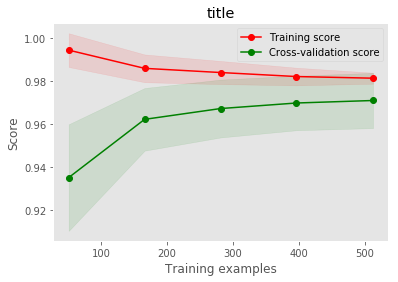

In [83]:
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)
plot_learning_curve(lr, 'title', train_X, train['phenotype_status'].values, cv=cv, n_jobs=4)

In [24]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LogisticRegressionCV(cv=10)
# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.4)
sfm.fit(train_X,train['phenotype_status'])
n_features = sfm.transform(train_X).shape[1]

In [25]:
n_features

124

In [ ]:
thresholds = [0.1,0.2,0.3,0.4,0.5]
cv_auroc = []
for t in thresholds:
    
    auroc = []
    lr = LogisticRegression()
    kf = StratifiedKFold(10)
    TCRs = train.drop(['sample_name','phenotype_status'],axis=1).columns.values
    for train_index,test_index in kf.split(train_X,train_y): # for each cv round
    #     X_train, X_test = X[train_index], X[test_index]
    #     y_train, y_test = y[train_index], y[test_index]

        X_train, X_test = train_X.iloc[train_index].values, train_X.iloc[test_index].values
        y_train, y_test = train_y[train_index], train_y[test_index]

        # We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
        
        # Set a minimum threshold of 0.25
        sfm = SelectFromModel(lr, threshold=t)
        sfm.fit(X_train,y_train)
        train_X_new = sfm.transform(X_train,y_train)
        test_X_new = sfm.transform(X_test)
        
        auroc.append(roc_auc_score(y_test,lr.predict_proba(X_test)[:,1]))
    print('threshold:',t,'')
    cv_auroc.append(np.mean(auroc))